# SL-Ensemble in Basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinPlot import *
from utils.BasinInit import *

### Perturbing initial conditions

In [6]:
sample_args = {
    "g": 9.81,
    "f": 0.0012,
    }

In [7]:
L = 8

In [8]:
lvl_grid_args = initGridSpecs(L)

args = {
    "nx": lvl_grid_args["nx"],
    "ny": lvl_grid_args["ny"],
    "dx": lvl_grid_args["dx"],
    "dy": lvl_grid_args["dy"],
    "gpu_ctx": gpu_ctx,
    "gpu_stream": gpu_stream,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
    }

In [9]:
data_args = make_init_steady_state(args, a=3, bump_fractal_dist=7)


In [10]:
init_model_error_basis_args = {
    "basis_x_start": 1, 
    "basis_x_end": 6,
    "basis_y_start": 2,
    "basis_y_end": 7,

    "kl_decay": 1.25,
    "kl_scaling": 0.18,
}

In [11]:
sim_model_error_basis_args = {
    "basis_x_start": 1, 
    "basis_x_end": 7,
    "basis_y_start": 2,
    "basis_y_end": 8,

    "kl_decay": 1.25,
    "kl_scaling": 0.004,
}


### Ensemble

In [12]:
from utils.BasinSL import *

In [13]:
Ne = 50

In [14]:
SL_ensemble = initSLensemble(Ne, args, data_args, sample_args, 
                             init_model_error_basis_args=init_model_error_basis_args, 
                             sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=60.0)

### Variance estimation

In [15]:
def g_functional(SL_ensemble):
    return (SLdownload(SL_ensemble) - SLestimate(SL_ensemble, np.mean)[:,:,:,np.newaxis])**2

In [16]:
g_functional(SL_ensemble).shape

(3, 512, 256, 50)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

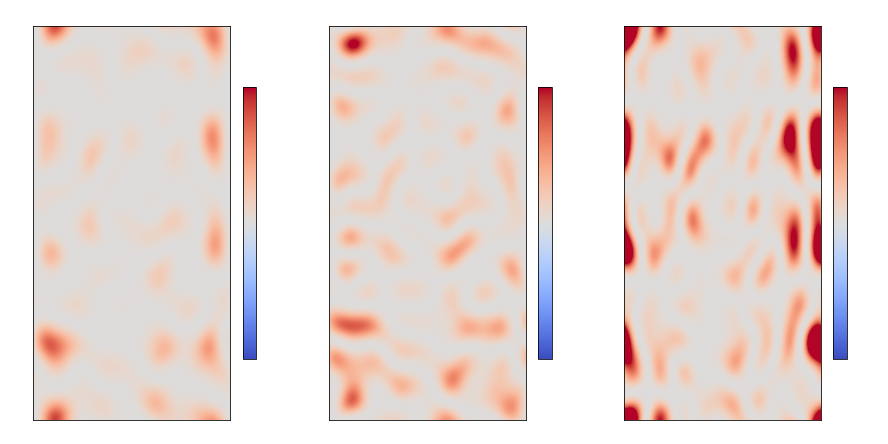

In [17]:
imshow3(g_functional(SL_ensemble)[:,:,:,0], eta_vlim=0.1, huv_vlim=250)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

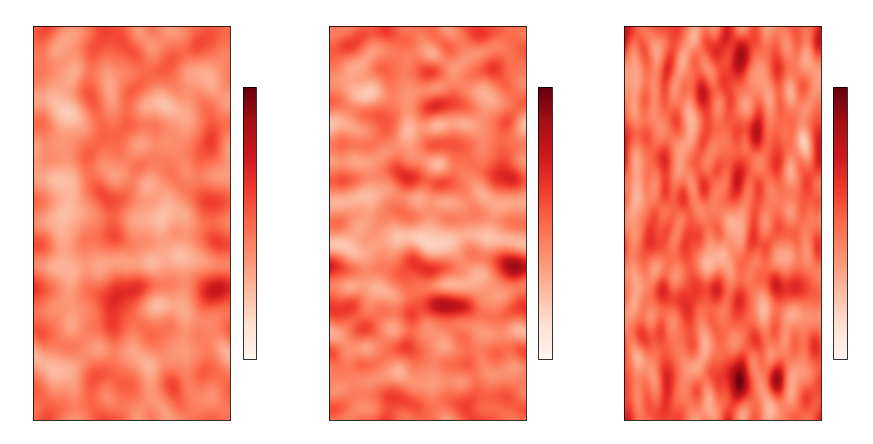

In [18]:
imshow3var(np.mean(g_functional(SL_ensemble), axis=-1), eta_vlim=0.015, huv_vlim=50)

In [19]:
np.mean(np.var(g_functional(SL_ensemble), axis=-1), axis=(1,2))

array([1.07730106e-04, 1.22393835e+03, 1.50689844e+03], dtype=float32)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

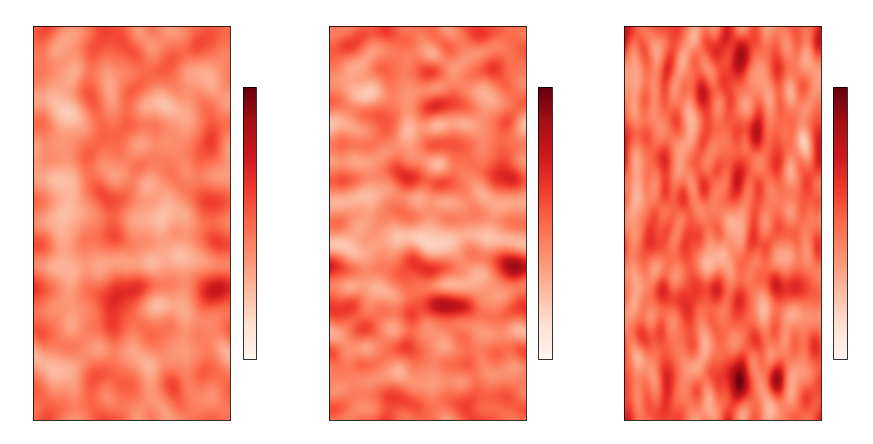

In [20]:
imshow3var(SLestimate(SL_ensemble, np.var), eta_vlim=0.015, huv_vlim=50)